#### Import libraries

In [1]:
# Basic Libraries
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

# Libraries for text sentiments calculations
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
#pip install vaderSentiment

# Libraries for text processing
import re
import nltk
#nltk.download()
#nltk.download('wordnet') 
#nltk.download('universal_tagset')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer

#  Libraries for text vizualization
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# pip install wordcloud
import matplotlib.pyplot as plt

# Creating DataFrame
listData = pd.read_csv("listings_sentiment.csv")
listDataFrame = pd.DataFrame(listData)
# listData.head()

# Importing Dataset - review.csv for cleaning
reviewsData = pd.read_csv("reviews.csv")
reviewsData.info()

# Drop rows with any empty cells
reviewsData = reviewsData.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


# Data preparation  
Preparing the data columns to be used in calculating 'total_score_metric', which is used to determine if a listing is successful, using existing ratings and user sentiments.

Sentiment Analysis Score which was used in calculating this metric is calulated and appended to the raw data in SentimentAnalysis.ipynb

In [2]:
# reviews_per_month converted to score
conditions = [
    (listDataFrame['reviews_per_month'] >= 5),
    (listDataFrame['reviews_per_month'] >= 4) & (listDataFrame['reviews_per_month'] < 5),
    (listDataFrame['reviews_per_month'] >= 3) & (listDataFrame['reviews_per_month'] < 4),
    (listDataFrame['reviews_per_month'] >= 2) & (listDataFrame['reviews_per_month'] < 3),
    (listDataFrame['reviews_per_month'] >= 1) & (listDataFrame['reviews_per_month'] < 2),
    (listDataFrame['reviews_per_month'] < 1)]
rev = [0.05, 0.04, 0.03, 0.02, 0.01, 0]

listDataFrame['reviews_per_month'] = np.select(conditions, rev, default=0)

# convert T/F to score values
# true = 0.05
# false = 0
tf_var = {'t' : 0.05 , 'f' : 0 }
listDataFrame['is_location_exact'] = listDataFrame['is_location_exact'].map(tf_var)
listDataFrame['host_is_superhost'] = listDataFrame['host_is_superhost'].map(tf_var)
listDataFrame.head()

# add last column for final review score (1.00), weightages are indicated by the divisor
listDataFrame['review_scores_rating'] = listDataFrame['review_scores_rating']/1000
listDataFrame['review_scores_accuracy'] = listDataFrame['review_scores_accuracy']/100
listDataFrame['review_scores_cleanliness'] = listDataFrame['review_scores_cleanliness']/100
listDataFrame['review_scores_checkin'] = listDataFrame['review_scores_checkin']/100
listDataFrame['review_scores_value'] = listDataFrame['review_scores_value']/100
listDataFrame['review_scores_communication'] = (listDataFrame['review_scores_communication']/100) / 2
listDataFrame['review_scores_location'] = (listDataFrame['review_scores_location']/100) / 2
# This was calculated and added to the dataset in SentimentAnalysis.ipynb
listDataFrame['sentiment_score'] = listDataFrame['sentiment_score']/4

listDataFrame['total_score'] = listDataFrame['review_scores_rating'] + listDataFrame['review_scores_accuracy'] + listDataFrame['review_scores_cleanliness'] + listDataFrame['review_scores_checkin'] + listDataFrame['review_scores_value'] + listDataFrame['review_scores_communication'] + listDataFrame['review_scores_location'] + listDataFrame['reviews_per_month'] + listDataFrame['is_location_exact'] + listDataFrame['host_is_superhost'] + listDataFrame['sentiment_score'];

# for better accuracy
listDataFrame['total_score'] = listDataFrame['total_score'] * 100;

# round to 2 decimal places
listDataFrame = listDataFrame.round(2)

In [3]:
#drop rows that has total_score below median
median = listDataFrame['total_score'].quantile()
listDataFrame = listDataFrame[listDataFrame.total_score > median]

#id list of successful values 
successful_list = listDataFrame['id'].to_list()

print("length of successful list:", len(successful_list))


length of successful list: 1578


,total_score
count,1578.000000
mean,91.602319
std,3.071025
min,87.410000
25%,88.920000
50%,90.750000
75%,94.307500
max,98.870000


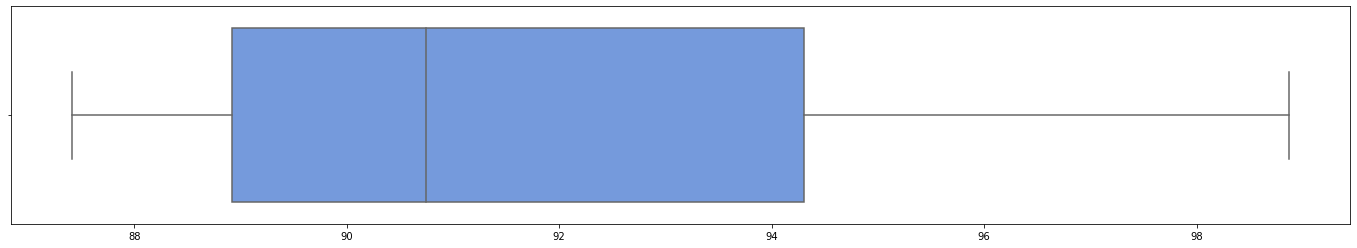

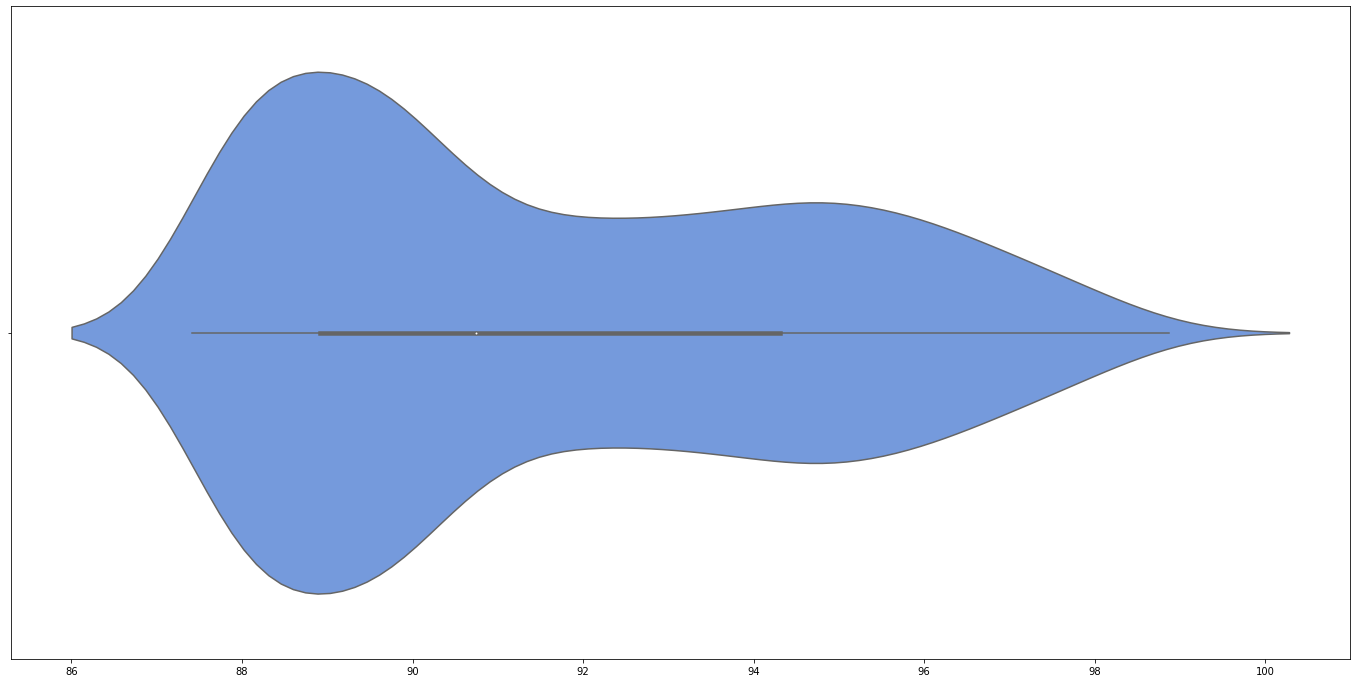

In [4]:
#Statistical description of adjusted list
total_median = pd.DataFrame(listDataFrame['total_score'])

f, axes = plt.subplots(1, 1, figsize=(24, 4))
sb.boxplot(total_median, orient = "h", color = "cornflowerblue")

f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.violinplot(total_median, color = "cornflowerblue")

total_median.describe()

# Priceclass Analysis
Categorize the listings according to price class, observe if there are any differences in 'keywords' found in reviews/descriptions of listings in different classes

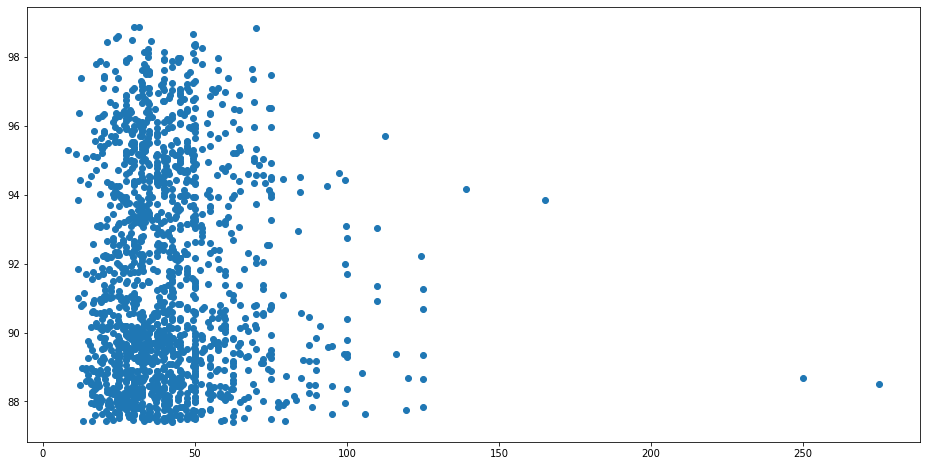

In [5]:
#removing dollar signs and commas from price for calculation
listDataFrame['price'] = listDataFrame['price'].replace({'\$':''}, regex = True)
listDataFrame['price'] = listDataFrame['price'].replace({'\,':''}, regex = True)
listDataFrame['price_acc'] = listDataFrame['price'].astype(float) / listDataFrame['accommodates']

# Scatterplot
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = 'price_acc', y = 'total_score', data = listDataFrame)

# Clustering
We want to sort this data into clusters, and examine each cluster individually

In [6]:
# Import KMeans from sklearn.cluster
from sklearn.cluster import KMeans

# Guess the Number of Clusters
num_clust = 3

# Create Clustering Model using KMeans
kmeans = KMeans(n_clusters = num_clust)

pairData = pd.DataFrame(listDataFrame[['price_acc', 'total_score']])

# Fit the Clustering Model on the Data
kmeans.fit(pairData)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
# Predict the Cluster Labels
labels = kmeans.predict(pairData)

# Append Labels to the Data
listDataFrame["Cluster"] = pd.Categorical(labels)

In [8]:
# Print the Cluster Centers
print("Features", "\tprice_acc", "\ttotal_score")
print()

for i, center in enumerate(kmeans.cluster_centers_):
    print("Cluster", i, end=":\t")
    for coord in center:
        print(round(coord, 2), end="\t\t")
    print()

Features 	price_acc 	total_score

Cluster 0:	30.52		91.58		
Cluster 1:	106.66		90.38		
Cluster 2:	54.89		91.78		


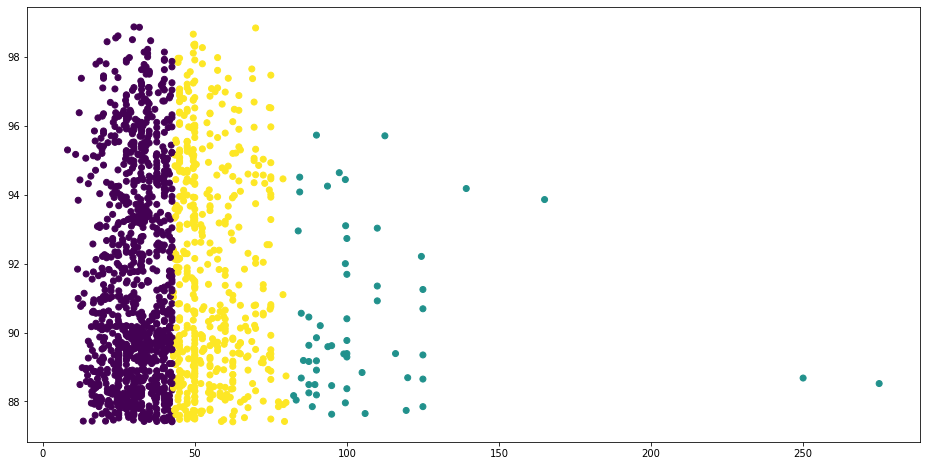

In [9]:
# Visualize the Clusters in the Data
f, axes = plt.subplots(1, 1, figsize=(16,8))

# c= parameter is for colour, we are colouring by the labels
plt.scatter(x = "price_acc", y = "total_score", c = "Cluster", cmap = 'viridis', data = listDataFrame)

##### we can see that the clusters are quite neatly broken into price classes, low, middle and high

In [10]:
high_priceclass = []
med_priceclass = []
low_priceclass = []

# determine which cluster corresponds to which price range
centers = [(i, center[0]) for (i, center) in enumerate(kmeans.cluster_centers_)]
centers.sort(key=lambda x: x[1])
low_clus = centers[0][0]
med_clus = centers[1][0]
high_clus = centers[2][0]

# retrieve the ids of the listings in each cluster
for index, row in listDataFrame.iterrows():
    if row['Cluster'] == low_clus:
        low_priceclass.append(row['id'])
    elif row['Cluster'] == med_clus:
        med_priceclass.append(row['id'])
    elif row['Cluster'] == high_clus:
        high_priceclass.append(row['id'])

print("Size of high_priceclass:", len(high_priceclass))
print("Size of med_priceclass:\t", len(med_priceclass))
print("Size of low_priceclass:\t", len(low_priceclass))

Size of high_priceclass: 58
Size of med_priceclass:	 512
Size of low_priceclass:	 1008


***
## Explorations and visualization of 'Reviews' of the successful listings

In [11]:
def peekMinComment(start=0, end=5):
    keys_list = list(comments_minimal.keys())
    for i in range(start, end):
        key = keys_list[i]
        listing_obj = comments_minimal[key]
        noOfEntries = listing_obj['noOfEntries']
        wordList = listing_obj['wordList']
        wordList.sort()
        print("Listing id: " + str(key) + '\tNo of Entries: ' + str(noOfEntries) + '\n' +\
             "Words extracted:\n" + str(wordList) + '\n')

def peekOverallwords(start=0, end=5):
    for i in range(start,end):
        print(overall_words[i])

In [12]:
# Minimize dataframe to area of focus
dataset_min = reviewsData.loc[reviewsData['listing_id'].isin(successful_list)]

# Drop rows with any empty cells
dataset_min = dataset_min.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
dataset_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55468 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     55468 non-null  int64 
 1   id             55468 non-null  int64 
 2   date           55468 non-null  object
 3   reviewer_id    55468 non-null  int64 
 4   reviewer_name  55468 non-null  object
 5   comments       55468 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.0+ MB


### Preliminary exploration

In [13]:
#Fetch wordcount for each abstract
dataset_min['word_count'] = dataset_min['comments'].apply(lambda x: len(str(x).split(" ")))
dataset_min[['listing_id', 'comments','word_count']].head()

,listing_id,comments,word_count
0,7202016,Cute and cozy place. Perfect location to every...,9
1,7202016,Kelly has a great room in a very central locat...,70
2,7202016,"Very spacious apartment, and in a great neighb...",75
3,7202016,Close to Seattle Center and all it has to offe...,48
4,7202016,Kelly was a great host and very accommodating ...,61


In [14]:
# Creates a dictionary to store the resultant data: 
# { "listing_id" : 
#         { 
#           "noOfEntries" : noOfEntries,                  // Count of comments for that listings
#           "wordList"    : [list of extracted words]     // To store the meaningful words extracted
#         }
# }
comments_minimal = {}

# Initializing the dictionary
listing_ids = dataset_min['listing_id']
listing_ids.sort_values()

for listing_id in listing_ids:
    if listing_id in comments_minimal:
        comments_minimal[listing_id]['noOfEntries'] += 1
    else:
        comments_minimal[listing_id] = {'noOfEntries' : 1, 'wordList' : []}

In [15]:
# Define a list of tags that represents meaningful data. 
# Referrence to https://pythonprogramming.net/natural-language-toolkit-nltk-part-speech-tagging/
useful_tags = ['ADJ', 'ADV', 'VERB', 'X']

overall_words = []

# Lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

for index, row in dataset_min.iterrows():
    listing_id = row['listing_id']
    comment = row['comments']
    try:
        # Removes special characters
        text = re.sub('[^a-zA-Z]', ' ', comment)
        text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
        text = re.sub("(\\d|\\W)+"," ",text)
        text = text.lower()

        comment_tokenized = nltk.word_tokenize(text)  # Split the line of comment into a list of words.

        for i in range(0, len(comment_tokenized)):
            comment_tokenized[i] = wordnet_lemmatizer.lemmatize(comment_tokenized[i], pos="v")

        comment_tagged = nltk.pos_tag(comment_tokenized, tagset='universal') # Tag each words of the comment to extract relavent words.

        for word in comment_tagged:    
            if word[1] in useful_tags:
                overall_words.append(word[0])

                if word[0] not in comments_minimal[listing_id]['wordList']:
                    comments_minimal[listing_id]['wordList'].append(word[0])
                    
    except TypeError:
        print(comment)
        continue
        

In [16]:
# Filter list
filter_list = ['a', 'about', 'above', 'across', 'after', 'afterwards']
filter_list += ['again', 'against', 'all', 'almost', 'alone', 'along']
filter_list += ['already', 'also', 'although', 'always', 'am', 'among']
filter_list += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
filter_list += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
filter_list += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
filter_list += ['because', 'become', 'becomes', 'becoming', 'been']
filter_list += ['before', 'beforehand', 'behind', 'being', 'below']
filter_list += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
filter_list += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
filter_list += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
filter_list += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
filter_list += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
filter_list += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
filter_list += ['every', 'everyone', 'everything', 'everywhere', 'except']
filter_list += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
filter_list += ['five', 'for', 'former', 'formerly', 'forty', 'found']
filter_list += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
filter_list += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
filter_list += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
filter_list += ['herself', 'him', 'himself', 'his', 'how', 'however']
filter_list += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
filter_list += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
filter_list += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
filter_list += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
filter_list += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
filter_list += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
filter_list += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
filter_list += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
filter_list += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
filter_list += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
filter_list += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
filter_list += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
filter_list += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
filter_list += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
filter_list += ['some', 'somehow', 'someone', 'something', 'sometime']
filter_list += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
filter_list += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
filter_list += ['then', 'thence', 'there', 'thereafter', 'thereby']
filter_list += ['therefore', 'therein', 'thereupon', 'these', 'they']
filter_list += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
filter_list += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
filter_list += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
filter_list += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
filter_list += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
filter_list += ['whatever', 'when', 'whence', 'whenever', 'where', 'want']
filter_list += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
filter_list += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
filter_list += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
filter_list += ['within', 'without', 'would', 'yet', 'you', 'your']
filter_list += ['yours', 'yourself', 'yourselves']
filter_list += ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
filter_list += ['n\'t', 'airbnb', 'etc', 'put', 'just', 'pm', 'y', 'make', 'stay']
filter_list += ['really', 'need', 't', 'walk', 'apartment', 'be', 'definitely']
filter_list += ['great', 'fantastic', 'perfect', 'easy', 'place', 'seattle', 'time', 'wonderful', 'extremely']
filter_list += ['nice', 'welcome', 'recommend', 'home', 'house', 'thank', 'highly', 'little', 'right']
filter_list += ['arrive', 'come', 'didn', 'super', 'meet', 'leave', 'provide']
filter_list += ['good', 'felt', 'away', 'sean', 'short','use','look','locate', 'feel', 'enjoy','available']
filter_list += ['late','check','better', 'best','west','live','exactly','overall','amaze','sure','visit']
filter_list += ['early','able','love','awesome','excellent','safe','sleep','know','cool','spend','light','let']
filter_list += ['private','quick','offer','say','quite','long','main','expect','d','ll','ask','don','wasn']
filter_list += ['ready','wish','talk','ve','perfectly','answer','consider','work','probably','couldn']

filter_list = set(filter_list)

# Further reduce noises by removing words in the filter list
overall_words = [word for word in overall_words if not word in filter_list]

for key in comments_minimal:
    new_list = [word for word in comments_minimal[key]['wordList'] if not word in filter_list]
    comments_minimal[key]['wordList'] = new_list.copy()

***
#### Section to further clean the dataset manually during development only.

In [17]:
# Identify common words to create a filter list
fdist = nltk.FreqDist(overall_words)
fdist.most_common()

[('clean', 18505),
 ('comfortable', 17437),
 ('quiet', 8185),
 ('close', 7296),
 ('beautiful', 7023),
 ('downtown', 7023),
 ('lovely', 6691),
 ('friendly', 6537),
 ('helpful', 6371),
 ('accommodate', 4209),
 ('cozy', 3474),
 ('spacious', 3110),
 ('convenient', 2961),
 ('warm', 2851),
 ('absolutely', 2686),
 ('small', 2395),
 ('local', 2353),
 ('responsive', 2251),
 ('nearby', 2152),
 ('help', 2149),
 ('appreciate', 2098),
 ('include', 1939),
 ('public', 1868),
 ('eat', 1785),
 ('think', 1778),
 ('fresh', 1777),
 ('return', 1760),
 ('explore', 1737),
 ('pleasant', 1669),
 ('easily', 1665),
 ('cute', 1658),
 ('gracious', 1649),
 ('new', 1625),
 ('especially', 1596),
 ('pretty', 1590),
 ('relax', 1587),
 ('far', 1492),
 ('decorate', 1491),
 ('sweet', 1484),
 ('happy', 1480),
 ('big', 1478),
 ('pike', 1467),
 ('large', 1431),
 ('open', 1402),
 ('extra', 1358),
 ('equip', 1329),
 ('park', 1327),
 ('respond', 1307),
 ('incredibly', 1267),
 ('bed', 1252),
 ('comfy', 1241),
 ('set', 1234),
 ('

***
### Visualization of the most commonly used words.

[Text(0, 0, 'clean'),
 Text(0, 0, 'comfortable'),
 Text(0, 0, 'quiet'),
 Text(0, 0, 'close'),
 Text(0, 0, 'beautiful'),
 Text(0, 0, 'downtown'),
 Text(0, 0, 'lovely'),
 Text(0, 0, 'friendly'),
 Text(0, 0, 'helpful'),
 Text(0, 0, 'accommodate'),
 Text(0, 0, 'cozy'),
 Text(0, 0, 'spacious'),
 Text(0, 0, 'convenient'),
 Text(0, 0, 'warm'),
 Text(0, 0, 'absolutely'),
 Text(0, 0, 'small'),
 Text(0, 0, 'local'),
 Text(0, 0, 'responsive'),
 Text(0, 0, 'nearby'),
 Text(0, 0, 'help')]

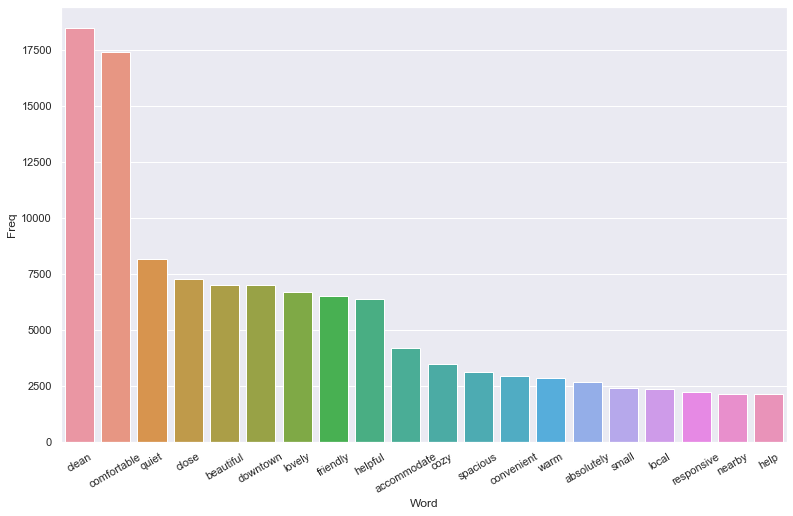

In [18]:
corpus = list(overall_words)

#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

#Barplot of most freq words
sb.set(rc={'figure.figsize':(13,8)})
g = sb.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [19]:
#peekOverallwords()
#peekMinComment()

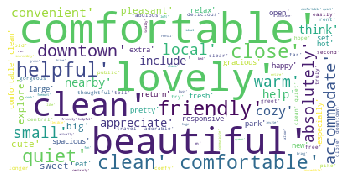

In [20]:
#Word cloud
%matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=filter_list,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("top_word_in_reviews.png", dpi=900)